In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [19]:
%pwd

'/content/drive/My Drive/ColabNote/얼굴인식/picture'

In [0]:
#필요한 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as pylab
from sklearn.metrics import pairwise_distances_argmin
from skimage.io import imread
from sklearn.utils import shuffle
from skimage import img_as_float

In [21]:
# 드라이브에 있는 사진 이름 가져오기
import glob
images=sorted(glob.glob("*.BMP"))   #1350개의 파일 이름 담겨져있음

print(images)
print(len(images))

['mpeg_0001_0001.BMP', 'mpeg_0001_0002.BMP', 'mpeg_0001_0003.BMP', 'mpeg_0001_0004.BMP', 'mpeg_0001_0005.BMP', 'mpeg_0002_0001.BMP', 'mpeg_0002_0002.BMP', 'mpeg_0002_0003.BMP', 'mpeg_0002_0004.BMP', 'mpeg_0002_0005.BMP', 'mpeg_0003_0001.BMP', 'mpeg_0003_0002.BMP', 'mpeg_0003_0003.BMP', 'mpeg_0003_0004.BMP', 'mpeg_0003_0005.BMP', 'mpeg_0004_0001.BMP', 'mpeg_0004_0002.BMP', 'mpeg_0004_0003.BMP', 'mpeg_0004_0004.BMP', 'mpeg_0004_0005.BMP', 'mpeg_0005_0001.BMP', 'mpeg_0005_0002.BMP', 'mpeg_0005_0003.BMP', 'mpeg_0005_0004.BMP', 'mpeg_0005_0005.BMP', 'mpeg_0006_0001.BMP', 'mpeg_0006_0002.BMP', 'mpeg_0006_0003.BMP', 'mpeg_0006_0004.BMP', 'mpeg_0006_0005.BMP', 'mpeg_0007_0001.BMP', 'mpeg_0007_0002.BMP', 'mpeg_0007_0003.BMP', 'mpeg_0007_0004.BMP', 'mpeg_0007_0005.BMP', 'mpeg_0008_0001.BMP', 'mpeg_0008_0002.BMP', 'mpeg_0008_0003.BMP', 'mpeg_0008_0004.BMP', 'mpeg_0008_0005.BMP', 'mpeg_0009_0001.BMP', 'mpeg_0009_0002.BMP', 'mpeg_0009_0003.BMP', 'mpeg_0009_0004.BMP', 'mpeg_0009_0005.BMP', 'mpeg_001

In [0]:
# 파일 이름 train set과 test set으로 나누기
# 학습 % 36~115, 151~230  ==> PCA()실행에 사용
# 테스트 % 1~35, 116~150, 231~270  ==> PCA()의 components_ 활용해 인식
fname_train=[]          #trainset에 들어갈 파일 이름들
fname_test=[]           #testset에 들어갈 파일 이름들

for i in range(0, 1350):
  if((i>=35*5 and i<115*5)or(i>=150*5 and i<230*5)):
    fname_train.append(images[i])
  else:
    fname_test.append(images[i])

In [0]:
fname_test

In [0]:
# 데이터셋 만들기
faces_train=[]              # 학습 데이터 셋 들어있는 행렬
faces_test=[]               # 테스트 데이터 셋 들어있는 행렬

def make_train(filename):
  img=img_as_float(imread(filename))      # 파일 이름이 filename인 사진 데이터 가져오기
  temp=[]
  for i in range(0, 56):
    for j in range(0, 46):
      temp.append(img[i][j])        # 56X46 -> 1X2576
  faces_train.append(temp)

def make_test(filename):
  img=img_as_float(imread(filename))      # 파일 이름이 filename인 사진 데이터 가져오기
  temp=[]
  for i in range(0, 56):
    for j in range(0, 46):
      temp.append(img[i][j])        # 56X46 -> 1X2576
  faces_test.append(temp)

In [0]:
# 데이터셋 만들기
for i in range(0, 800):
  make_train(fname_train[i])

for i in range(0, 550):
  make_test(fname_test[i])

In [30]:
print(len(faces_train))     #800개 = 학습데이터
len(faces_test)             #550개 = 테스트데이터

800


550

(800, 800)


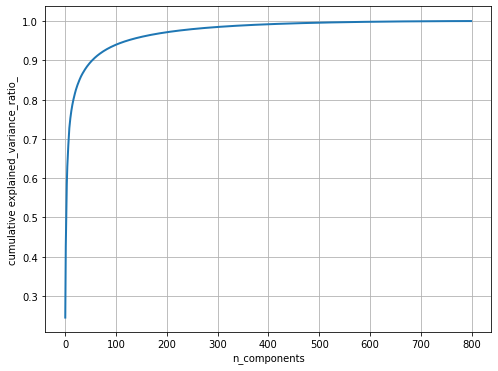

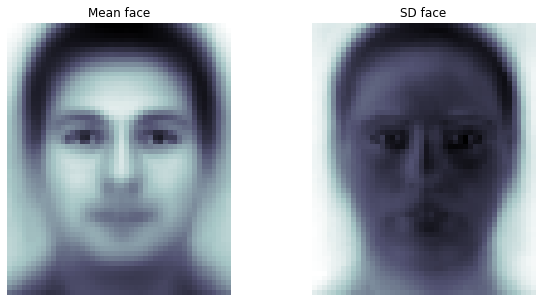

In [31]:
# 적정 주성분 수 찾기
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

n_comp = 800        #학습 데이터 대상으로 찾을 것이므로
#평균 및 분산 관련 계산은 StandardScaler()로 계산
#주성분 찾는 것은 PCA()로 계산
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_comp))])
faces_proj = pipeline.fit_transform(faces_train)                                #학습 데이터 800개 주성분으로 투영
print(faces_proj.shape)

mean_face = np.reshape(pipeline.named_steps['scaling'].mean_, (56,46))          # 각 얼굴의 화소/인덱스별로 평균 계산
sd_face = np.reshape(np.sqrt(pipeline.named_steps['scaling'].var_), (56,46))    #얼굴의 차이값(각 얼굴 화소  - 해당 화소/인덱스의 평균) 

#고유값 누적해서 그래프로 보여주기
pylab.figure(figsize=(8, 6))
variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_
pylab.plot(np.cumsum(variance_ratio), linewidth=2)
pylab.grid(), pylab.axis('tight'), pylab.xlabel('n_components')
pylab.ylabel('cumulative explained_variance_ratio_')
pylab.show()

#meanface, sdface 보여주기
pylab.figure(figsize=(10,5))
pylab.subplot(121), pylab.imshow(mean_face, cmap='bone')
pylab.axis('off'), pylab.title('Mean face')
pylab.subplot(122), pylab.imshow(sd_face, cmap='bone')
pylab.axis('off'), pylab.title('SD face')
pylab.show()

In [32]:
# 적정 주성분 수 찾기
pca = PCA(0.9) 

#학습 데이터 faces_train에 대해 PCA() 실행
pca.fit(faces_train) 

#pca = PCA(0.9)로 찾은 적정수 확인
print(pca.n_components_) #n_components 일 때의 적용된 주성분 수

43


In [33]:
print(pca.components_.shape)

(43, 2576)


In [34]:
# 90%의 설명력 가지는 주성분 수 = 43개

n_comp = 43
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_comp))])
faces_proj = pipeline.fit_transform(faces_train)
print(faces_proj.shape)

mean_face = np.reshape(pipeline.named_steps['scaling'].mean_, (56,46))
sd_face = np.reshape(np.sqrt(pipeline.named_steps['scaling'].var_), (56,46))


variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_
variance_ratio      # 상위 43개의 기여도

(800, 43)


array([0.24514565, 0.18139187, 0.08836337, 0.07033339, 0.04421971,
       0.02873757, 0.02558333, 0.02391053, 0.01986402, 0.01403808,
       0.01113074, 0.00977556, 0.009317  , 0.00798456, 0.00728914,
       0.00682434, 0.00593023, 0.00562387, 0.00525857, 0.00506331,
       0.00494897, 0.00453397, 0.00408034, 0.00402449, 0.00373467,
       0.00345223, 0.0033866 , 0.00326411, 0.00317148, 0.00310671,
       0.0028617 , 0.00279073, 0.00265223, 0.00243217, 0.00227369,
       0.00223626, 0.00220106, 0.00213446, 0.00209607, 0.00201519,
       0.00195818, 0.00189992, 0.00184841])

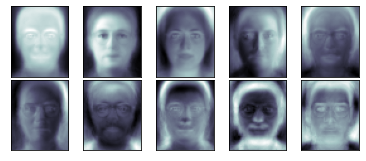

In [35]:
#상위 10개 고유얼굴
'''
print('예를 들어, 1번째 주성분:', pca.components_[1, :])
print('1개의 주성분 크기: ', len(pca.components_[1, :]))
'''

fig = pylab.figure(figsize=(5,2))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    face = np.reshape(pca.components_[i, :], (56, 46))
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    ax.imshow(face, cmap='bone')
pylab.show()

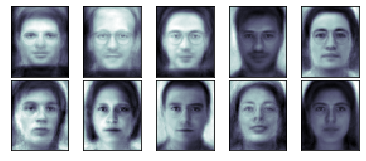

In [36]:
# 얼굴 재구성
faces_inv_proj = pipeline.named_steps['pca'].inverse_transform(faces_proj)  # projection 시켰던 것을 다시 얼굴 영역으로 가져옴
faces_inv_proj = np.reshape(faces_inv_proj, (800, 56, 46))  # 800개를 56X46로 reshape

fig = pylab.figure(figsize=(5,2))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

j = 1
np.random.seed(0) # 매번 같은 임의값 지정 위해
for i in np.random.choice(range(800), 10):      #랜덤으로 10개만 뽑아봄
    reconst_face = mean_face + sd_face * faces_inv_proj[i, :]   # i번째 얼굴 완성! 살 다시 붙이기
    ax = fig.add_subplot(2, 5, j, xticks=[], yticks=[])
    ax.imshow(reconst_face, cmap='bone', interpolation='nearest')
    j += 1

pylab.show()

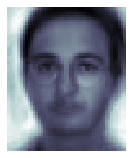

=
0.24514565069137956 X


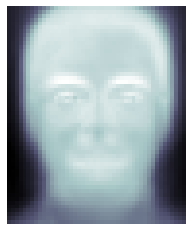

+
0.18139186745500432 X


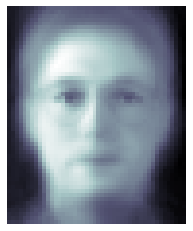

+...+


In [37]:
# 고유분해
fig = pylab.figure(figsize=(5,2))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
reconst_face = mean_face + sd_face * faces_inv_proj[0, :]   # i번째 얼굴 완성! 살 다시 붙이기
pylab.imshow(reconst_face, cmap='bone', interpolation='nearest')
pylab.axis('off')
pylab.show()
print("=")

print(variance_ratio[0], 'X')
face = np.reshape(pca.components_[0, :], (56, 46))
pylab.imshow(face, cmap='bone')
pylab.axis('off')
pylab.show()

print("+")
print(variance_ratio[1], 'X')
face = np.reshape(pca.components_[1, :], (56, 46))
pylab.imshow(face, cmap='bone')
pylab.axis('off')
pylab.show()

print("+...+")

In [0]:
# 테스트 데이터 특징벡터 추출하기
# 테스트 % 1~35, 116~150, 231~270 => 550개
# ID 110개, 각 ID당 5개의 샘플

newfaces_proj = pca.transform(faces_test) 

In [39]:
newfaces_proj[0]

array([-8.12830258e+00, -3.83947438e-02, -4.19375647e+00, -7.43451510e-01,
       -1.65628109e+00, -4.39353930e+00,  2.86083409e+00, -1.26080775e+00,
        1.92948742e+00,  1.16452739e+00,  8.29235924e-01,  2.23750859e+00,
        9.50670192e-01,  8.12942599e-01,  7.32329445e-01, -3.23025946e-01,
       -3.71203701e-03,  1.09336681e+00,  2.19355253e+00,  7.72419271e-01,
        2.50038346e-01,  3.77827453e-01,  2.78386400e-01,  5.48946284e-03,
        1.20856755e+00, -1.55644814e-01, -6.59774834e-02, -1.38383387e+00,
        7.48730335e-01,  6.51766987e-02,  4.14634018e-01, -1.45818724e-01,
        1.48466104e-01, -9.69675238e-02, -5.76793676e-01, -8.16808755e-02,
        1.06406017e-01,  3.12138540e-01, -4.22313181e-01, -5.08003159e-01,
       -1.17491427e-01, -7.28383746e-01, -5.43068687e-02])

In [0]:
# 테스트 데이터의 특징벡터 간 거리 구하기

dist=[]
for i in range(0, 550):
  for j in range(0, 550):
    distance=np.sqrt(np.sum((newfaces_proj[i]-newfaces_proj[j])**2))
    dist.append(distance)

In [41]:
dist_test=np.array(dist).reshape((550, 550))
print(dist_test.shape)
dist_test

(550, 550)


array([[ 0.        ,  6.51751065,  3.03653274, ..., 17.2390291 ,
        18.68125492, 20.7404679 ],
       [ 6.51751065,  0.        ,  5.44877396, ..., 18.30199784,
        18.70135192, 21.32999919],
       [ 3.03653274,  5.44877396,  0.        , ..., 17.41591706,
        18.54882618, 20.82099162],
       ...,
       [17.2390291 , 18.30199784, 17.41591706, ...,  0.        ,
         9.21380212,  8.72592887],
       [18.68125492, 18.70135192, 18.54882618, ...,  9.21380212,
         0.        ,  6.35449414],
       [20.7404679 , 21.32999919, 20.82099162, ...,  8.72592887,
         6.35449414,  0.        ]])

In [0]:
# test data target set
# 테스트 % 1~35, 116~150, 231~270 => 550개

target=[]
for i in range(1, 271):
  for j in range(1, 6):
    if((i>=1 and i<=35)or(i>=116 and i<=150)or(i>=231 and i<=270)):
      target.append(i)

In [43]:
print(target)
print(len(target))

[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 129, 129, 129, 129,

In [0]:
# 최대 거리값 구해보기
temp=[]
for i in range(0, 110):
  temp.append(sorted(dist_test[5*i])[549])
print(sorted(temp))
print(np.argsort(temp))
print(sorted(dist_test[5*81])[549])

[22.7263019666078, 22.90020602375402, 23.44837964211341, 23.62195168091161, 23.83943491950213, 23.950167441211075, 24.125691657338752, 24.16351912216037, 24.179187397624087, 24.260839075771433, 24.30395856641601, 24.307235029699047, 24.324120372271633, 24.52309636341012, 24.575689556079322, 24.69605959103333, 24.719650788951814, 24.75695095707411, 24.76133688551501, 24.978552028758546, 24.992640718229637, 25.414297126584394, 25.456633895901536, 25.493394349520887, 25.495103340880007, 25.542553070612588, 25.629570821639984, 25.661451722656057, 25.67027988841545, 25.74700238281854, 25.834312358571577, 25.88002495262081, 25.91357622243875, 25.948640090313564, 25.985017867183345, 26.012702915470456, 26.042001387585756, 26.110726198474232, 26.142172410910746, 26.16670625891019, 26.17792793624566, 26.20930869819865, 26.21043599840359, 26.235184675418203, 26.49475262251269, 26.499146882987763, 26.51469994424391, 26.650206551410186, 26.670255143593163, 26.766232157902866, 26.766633117482566, 2

In [0]:
# identification 함수

def identification(target, dist_test):
  match=0
  for i in range(0, 110):
    qu_ID=target[5*i]
    index=np.argsort(dist_test[5*i])
    min_ID=target[index[1]]
    if(qu_ID==min_ID):
      match+=1

  print("result : ", match/110*100)

In [45]:
identification(target, dist_test)

result :  92.72727272727272


In [0]:
# verification 함수

def verification(target, dist_test):
  match=0
  for i in range(0, 110):
    cnt=0
    qu_ID=target[5*i]
    index=np.argsort(dist_test[5*i])            #dist_test를 오름차순으로 정렬한 후 해당되는 index 배열
    for j in range(1, 5):
      if(qu_ID == target[index[j]]):            #거리가 최소인 ID 4개 비교, index[0]은 자기자신이므로 뺀다
        cnt+=1
    match+=(cnt/4*100)

  print("result : ", match/110)

In [47]:
verification(target, dist_test)

result :  56.59090909090909


In [0]:
#거리별 임계치
Dth=[5, 10, 15, 20, 25, 30, 35]

In [0]:
# FAR

def FAR(Dth, target, dist_test):
  match=0
  for i in range(0, 110):
    dist_cnt=0
    ID_cnt=0

    qu_ID=target[5*i]
    for j in range(0, 550):
      if(dist_test[5*i][j] < Dth):
        dist_cnt+=1
        if(qu_ID != target[j]):
          ID_cnt+=1
    dist_cnt-=1                     #자기 자신 빼야하므로
    if(dist_cnt > 0):
      match+=(ID_cnt/dist_cnt*100)

  print("result : ", match/110)

In [53]:
for i in Dth:
  print(f"임계치가 {i} 일 때 ", end='')
  FAR(i, target, dist_test)

임계치가 5 일 때 result :  2.7272727272727266
임계치가 10 일 때 result :  77.9260209896016
임계치가 15 일 때 result :  97.13052318332554
임계치가 20 일 때 result :  98.91485157539645
임계치가 25 일 때 result :  99.2431669789932
임계치가 30 일 때 result :  99.27118552172516
임계치가 35 일 때 result :  99.27115862831104


In [0]:
# FRR

def FRR(Dth, target, dist_test):
  match=0
  for i in range(0, 110):
    dist_cnt=0
    ID_cnt=0

    qu_ID=target[5*i]
    for j in range(0, 550):
      if(dist_test[5*i][j] > Dth):
        dist_cnt+=1
        if(qu_ID == target[j]):
          ID_cnt+=1
    if(dist_cnt > 0):
      match+=(ID_cnt/dist_cnt*100)

  print("result : ", match/110)

In [55]:
for i in Dth:
  print(f"임계치가 {i} 일 때 ", end='')
  FRR(i, target, dist_test)

임계치가 5 일 때 result :  0.502649353134086
임계치가 10 일 때 result :  0.2319817353881016
임계치가 15 일 때 result :  0.02692672927301294
임계치가 20 일 때 result :  0.018957907520957377
임계치가 25 일 때 result :  0.01855287569573284
임계치가 30 일 때 result :  0.03367003367003367
임계치가 35 일 때 result :  0.0
